In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import sensemakr
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Set up paths
main_path = Path('1_sample_selection.py').resolve().parents[3] / 'Data' / 'elsa_10' / 'tab'
derived_path = Path('1_sample_selection.py').resolve().parents[3] / 'Data' / 'derived_10'
figure_path = Path('1_sample_selection.py').resolve().parents[2] / 'output' / 'figure'
table_path = Path('1_sample_selection.py').resolve().parents[2] / 'output' / 'table'

# Read data
main_10 = pd.read_csv(derived_path / 'wave_10_pca.csv')

In [3]:
# Get the same sample used in 5_iptw.py
sample = main_10.loc[(main_10['SCINNO05'] != 1) & (main_10['SCINNO06'] != 1), :]  # remove reverse causality
sample= sample.dropna(subset=['PC1_b', 'total_income_bu_d', 'age', 'sex', 'ethnicity', 'edu_age', 'edu_qual', 'n_deprived', 'employ_status', 'marital_status', 'memory', 'numeracy', 'comprehension'])
sample['PC1_b'].value_counts(dropna=False)  # 1: 1562, 0: 1132 (N = 2694)

PC1_b
1.0    2113
0.0    1447
Name: count, dtype: int64

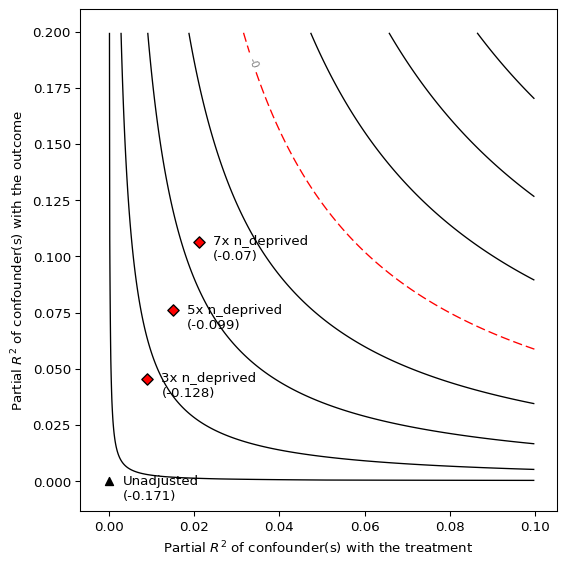

In [4]:
# self-reported health
srh_ols = smf.ols('srh ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                  data=sample).fit()
srh_sense = sensemakr.Sensemakr(model=srh_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                kd=[3, 5, 7])
srh_sense.plot(lim_y=0.20, lim=0.10, label_bump_y=-0.008)

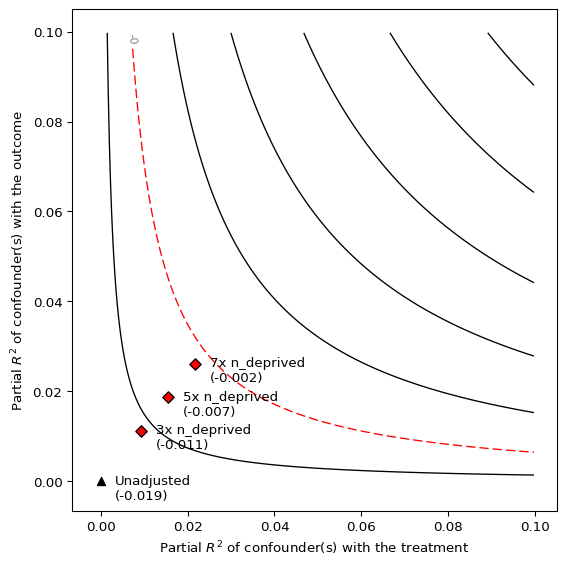

In [5]:
# diabetes
diabetes_ols = smf.ols('diabetes ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                       data=sample).fit()
diabetes_sense = sensemakr.Sensemakr(model=diabetes_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                     kd=[3, 5, 7])
diabetes_sense.plot(lim_y=0.10, lim=0.10, label_bump_y=-0.004)

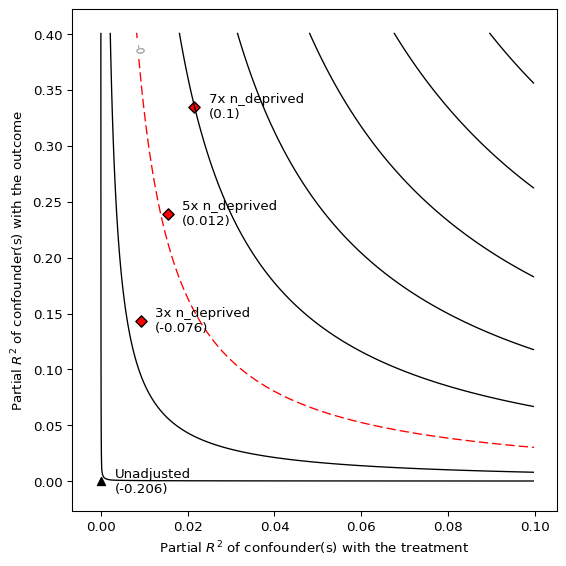

In [6]:
# mental health
cesd_ols = smf.ols('cesd ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                   data=sample).fit()
cesd_sense = sensemakr.Sensemakr(model=cesd_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                 kd=[3, 5, 7])
cesd_sense.plot(lim=0.10, label_bump_y=-0.01)

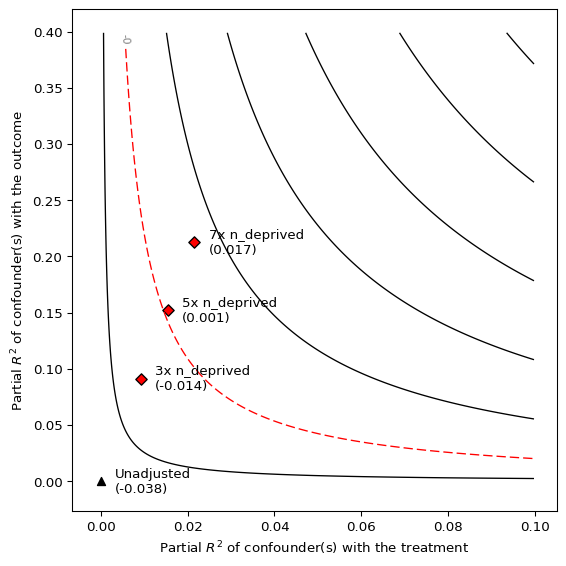

In [7]:
cesd_b_ols = smf.ols('cesd_b ~ PC1_b + total_income_bu_d + age + sex + ethnicity + edu_age + C(edu_qual) + n_deprived + employ_status + C(marital_status) + memory + numeracy + comprehension',
                     data=sample).fit()
cesd_b_sense = sensemakr.Sensemakr(model=cesd_b_ols, treatment='PC1_b', benchmark_covariates=['n_deprived'],
                                   kd=[3, 5, 7])
cesd_b_sense.plot(lim=0.10, label_bump_y=-0.01)

In [8]:
image_path = [figure_path / 'srh_sense.png', figure_path / 'diabetes_sense.png', figure_path / 'cesd_sense.png',
              figure_path / 'cesd_b_sense.png']

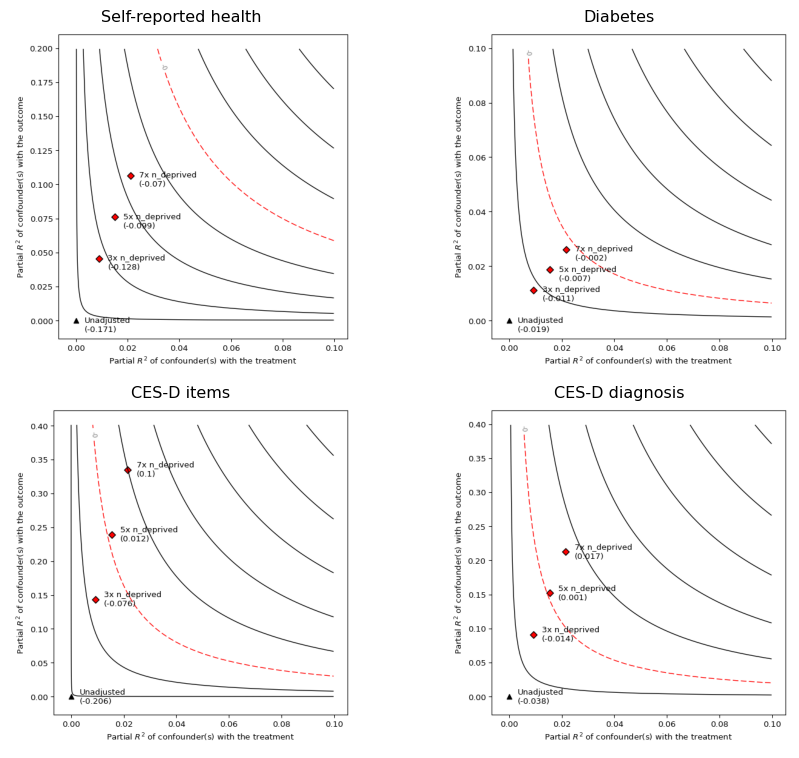

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

titles = ['Self-reported health', 'Diabetes', 'CES-D items', 'CES-D diagnosis']

for i, ax in enumerate(axs.flat):
    img = Image.open(image_path[i])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(titles[i])

plt.tight_layout()
plt.savefig(figure_path / 'sensitivity.png', dpi=300)